<a href="https://colab.research.google.com/github/yoyo4581/GCN_Onco/blob/main/GCN_OncoGene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML GCN Neural Network Model : Predicting Cancer Type from Commonly Associated Genes.

This lab notebook is to demonstrate the power of applying GCN in order to be able to reliably predict cancer type from a list of common gene terms.

- The source dataset is sourced from a curated database that I have created: OncoGeneDB
- All data is sourced on my website: https://oncogenedb.netlify.app/
- The database includes cancer types, associated multimodal bioinformatics experiments on GEO, and publications linked to said experiments.
- Commonly associated genes are data mined from these publications, and this is the source data that we will rely on.


#### In simple terms, our feature space includes genes, each data point is a publication defined by a set of genes, and each label is a cancer type.


### As a general criterion for the following workflow I will go over the key steps in this notebook:

1. Collecting the dataset: methods for saving.
2. Preprocessing the dataset: feature selection
3. Establishing benchmark: Ensemble Random Forest Classifier
4. Making GCNs work with our problem: Strategy
5. Building Dataset of Graphs: Encoding node features
7. First attempt at a GCN Neural Network
8. Rebalancing Dataset and Employing Regularization
9. Hyperparameter Tuning
10. Testing Final Model

# Collecting the Dataset

#### Familiarizing ourself with the database documents

In [ ]:
from pymongo import MongoClient

uri = "..."
cluster = MongoClient(uri)
db = cluster['Cancer_db']
Query_coll = db["Query_data"]
Gene_coll = db['Gene_data']
Labels_coll = db["Labels"]

In [ ]:
labels = list(Labels_coll.find())
labels[-1]

{'_id': ObjectId('6555a8957fe592b1b2a4735f'),
 'Primary Cancer Type': 'Blastoma',
 'Secondary Cancer Type': None,
 'Classification': 'Neuroblastoma',
 'Location': 'Anywhere, Adrenal gland, paraspinal ganglia, less often in the thorax, pelvis, and cervical areas.'}

In [ ]:
end_gene = list(Gene_coll.find())[-1]
end_gene

{'_id': ObjectId('66869f1cb9e8f8f0d8f14933'),
 'Abstract': ['MSX1', 'DLK1', 'NOTCH3', 'HEY1', 'NEUROD1'],
 'Body': [],
 'link': ObjectId('655ecde3585e672196438727')}

**Now by iterating through the cancer labels we can use the link parameter to identify the experiments, then the publications, identify empty publications, and if there are genes, generate a Count dictionary where the keys are the genes and the value is the frequency of their occurence in different parts of the publication.**

In [ ]:
from collections import Counter

count = 0
emptyDocs = 0
emptyDocsId =[]
dictArray = []
terminateBuild = False
for label in labels:
    exps = list(Query_coll.find({"link": label['_id']}))
    for exp in exps:
        publication = list(Gene_coll.find({"link": exp['_id']}, { "link":0}))
        if end_gene['link']==exp['_id']:
            terminateBuild = True

        #iterate through gene documents that are tied to a publication. More than 1 publication can be tied to a Query_coll document.
        for geneList in publication:
            if 'Redundant' in geneList:
                geneList = list(Gene_coll.find({'_id': geneList['Redundant']}, {"link":0}))
                geneList = geneList[0]
            listOfLists = [val for key, val in geneList.items() if key!='_id' and key!='Redundant']
            count += 1
            flattened_list = [item for sublist in listOfLists for item in sublist]
            # if there is genes in the document
            if flattened_list:
                counts = Counter(flattened_list)
                counts_dict = dict(counts)
                counts_dict['label']= ' '.join([ valLab for keyLab, valLab in label.items() if keyLab!='_id' and valLab])
                dictArray.append(counts_dict)
            # if there isn't genes in the document
            else:
                emptyDocsId.append(geneList['_id'])
                emptyDocs += 1
        if terminateBuild:
            break
    if terminateBuild:
        break

In [ ]:
print(dictArray[0:5])
print('\n', 'Number of Documents', len(dictArray))
print('\n', 'Number of Empty Documents', len(emptyDocsId))

[{'RELA': 1, 'DES': 1, 'FTL': 1, 'LGALS1': 1, 'MEG3': 1, 'MEST': 1, 'TUBB': 1, 'STMN1': 1, 'EGFR': 1, 'MDK': 1, 'NCL': 1, 'ZMYND10': 1, 'DNAH9': 1, 'TEKT1': 1, 'DYNLL1': 1, 'SPEF1': 1, 'MNS1': 1, 'DNAAF1': 1, 'IQCG': 1, 'SPAG16': 1, 'FOXJ1': 1, 'GEM': 1, 'CBS': 1, 'PTPN11': 1, 'STAT3': 1, 'label': 'Tumors Brain Tumors Ependymoma Brain'}, {'PDF': 1, 'IDH1': 1, 'label': 'Tumors Brain Tumors Ependymoma Brain'}, {'STAR': 1, 'label': 'Tumors Brain Tumors Ependymoma Brain'}, {'MGMT': 1, 'TST': 1, 'label': 'Tumors Brain Tumors Ependymoma Brain'}, {'OTX2': 2, 'EZH2': 2, 'SUZ12': 2, 'EED': 2, 'PDF': 1, 'JAZF1': 1, 'PHF1': 1, 'EPC1': 1, 'RELA': 1, 'label': 'Tumors Brain Tumors Ependymoma Brain'}]

 Number of Documents 9149

 Number of Empty Documents 2051


In [ ]:
import pandas as pd

df = pd.DataFrame(dictArray)
df.fillna(0, inplace=True)

# Select only the numerical columns (excluding 'label')
numerical_cols = df.select_dtypes(include=['float64']).columns

# Convert the numerical columns to integer
df[numerical_cols] = df[numerical_cols].astype(int)
df

,RELA,DES,FTL,LGALS1,MEG3,MEST,TUBB,STMN1,EGFR,MDK,...,CNBP,ARMC12,ARMCX3,NTSR2,GSK1,NPW,ZCCHC8,CLIP1,FXYD1,PAMR1
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['label']

0                    Tumors Brain Tumors Ependymoma Brain
1                    Tumors Brain Tumors Ependymoma Brain
2                    Tumors Brain Tumors Ependymoma Brain
3                    Tumors Brain Tumors Ependymoma Brain
4                    Tumors Brain Tumors Ependymoma Brain
                              ...                        
9144    Blastoma Neuroblastoma Anywhere, Adrenal gland...
9145    Blastoma Neuroblastoma Anywhere, Adrenal gland...
9146    Blastoma Neuroblastoma Anywhere, Adrenal gland...
9147    Blastoma Neuroblastoma Anywhere, Adrenal gland...
9148    Blastoma Neuroblastoma Anywhere, Adrenal gland...
Name: label, Length: 9149, dtype: object

### Label Encoding #1

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit the encoder to the labels column and transform it
df['label'] = le.fit_transform(df['label'])

# Get the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

list(label_mapping.items())[:5]

[('Blastoma Hepatoblastoma Fetal Liver cells', 0),
 ('Blastoma Medulloblastoma Brain, Cerebellum', 1),
 ("Blastoma Nephroblastoma Wilm's tumor kidney", 2),
 ('Blastoma Neuroblastoma Anywhere, Adrenal gland, paraspinal ganglia, less often in the thorax, pelvis, and cervical areas.',
  3),
 ('Blastoma Pleuropulmonary Blastoma Lung', 4)]

### Creating a Save CSV

In [ ]:
df.to_csv(".\Documents\geneDataframe_redundantAdded.csv", sep=',', index=False) #writes to a file all data

#### The data can be downloaded on my GitHub Repo

# Checking class balance

In [ ]:
counts = df['label'].value_counts()
counts

label
125    1195
29      892
35      777
83      662
106     652
       ... 
144       1
53        1
133       1
12        1
16        1
Name: count, Length: 153, dtype: int64

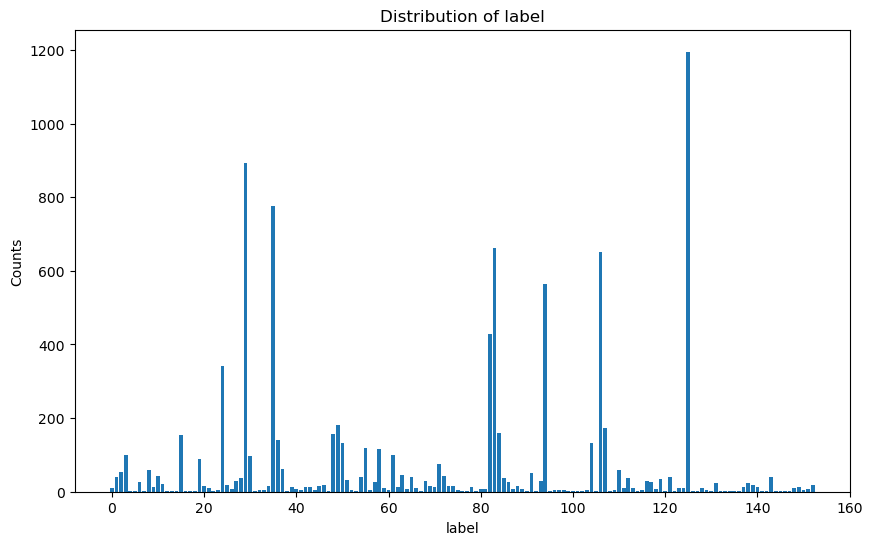

In [ ]:
import matplotlib.pyplot as plt

counts = df['label'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values)
plt.xlabel('label')
plt.ylabel('Counts')
plt.title(f'Distribution of label')
plt.show()

As we can see there is a drastic difference in class balance that needs to be addressed. One way of doing this is by removing classes that are too small to carry much of any substantiated insights.

In [ ]:
sig_labels = counts[counts>20].index.tolist()

print(counts[counts>20])
print(len(counts[counts>20]))

label
125    1195
29      892
35      777
83      662
106     652
94      563
82      429
24      341
49      181
107     174
84      160
48      157
15      155
36      140
50      133
104     132
55      120
58      115
3       100
61       99
30       96
19       89
71       76
37       61
8        60
110      59
2        53
91       50
63       46
10       44
72       42
54       41
121      41
143      40
65       40
1        39
85       38
112      37
28       36
119      34
51       32
93       30
68       29
27       29
116      28
117      27
6        27
57       27
86       26
131      24
138      24
Name: count, dtype: int64
51


In [ ]:
# We must eliminate any data points that don't belong to significant classes
# and if those points held any unique genes, we can remove them as they now no longer belong to any other class label.

dfComp = df[df['label'].isin(sig_labels)].reset_index(drop=True)

for col in dfComp.columns:
    if dfComp[col].sum() == 0:
        dfComp.drop(col, axis=1, inplace=True)

dfComp

,RELA,DES,FTL,LGALS1,MEG3,MEST,TUBB,STMN1,EGFR,MDK,...,CNBP,ARMC12,ARMCX3,NTSR2,GSK1,NPW,ZCCHC8,CLIP1,FXYD1,PAMR1
0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dfComp.to_csv(".\Documents\geneDataframe_significant.csv", sep=',', index=False) #writes to a file all data

Now instead of 9149 rows × 9339 columns, we have 8502 rows × 9043 columns. This is marginal. For a basic benchmarked random forest classifier we need to lower our feature space even more.

# Feature Selection through Feature Importance using a TreeClassifier

A quick and dirty way to remove genes that are less informative, is by using the gini impurity loss value from the removal of said feature from the dataset. We can do this using a Decision Tree Classifier.

In [ ]:
X = dfComp.drop('label', axis=1)
y = dfComp['label']

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Define the model
clf = ExtraTreesClassifier(n_estimators=200, class_weight='balanced')

# Fit the model
clf = clf.fit(X, y)

# Select features based on importance
model = SelectFromModel(clf, prefit=True)

# Transform X to the selected features
X_new = model.transform(X)

print("Number of selected features: ", X_new.shape[1])


C:\Users\Yahya\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of selected features:  1816


In [ ]:
# boolean mask that marks the original dataframe columns where True means the feature is selected
support = model.get_support()
features = X.columns[support]

Ximp = pd.DataFrame(X_new, columns=features)
Ximp

,RELA,DES,LGALS1,MEG3,MEST,STMN1,EGFR,MDK,NCL,ZMYND10,...,RBP3,MIR1208,DMTF1,SENP8,SCARA3,SBNO2,PCDHGC4,BEND2,NDUFA5,NHEG1
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(Ximp.shape)
print(y.shape)

(8502, 1816)
(8502,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Ximp, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=4, n_estimators=100, random_state=0, class_weight='balanced')
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns


def kfold_eval_docs(_clf, _X, _y):
    accs = []
    aucs = []
    f1s = []
    cms = []
    _niter = 5
    _X = np.array(_X)
    _y = np.array(_y)
    for i in range(_niter):
        print('Iteration', i)
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state = i)
        for train_index, test_index in kf.split(_X, _y):
            _clf.fit(_X[train_index], _y[train_index])
            ypred = _clf.predict(_X[test_index])
            ypred_proba= _clf.predict_proba(_X[test_index])
            accs += [accuracy_score(_y[test_index], ypred)]
            aucs += [roc_auc_score(_y[test_index], ypred_proba, multi_class='ovr', average='weighted')]
            f1s += [f1_score(_y[test_index], ypred, average='weighted')]
            cms.append(confusion_matrix(_y[test_index], ypred))

    cm_avg = np.mean(cms, axis=0)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm_avg, annot=True, fmt=".1f", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Create a mapping from the sklearn's classes_ attribute
    class_mapping = {i: label for i, label in enumerate(_clf.classes_)}

    return np.array(accs), np.array(aucs), np.array(f1s), cm_avg, class_mapping



Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


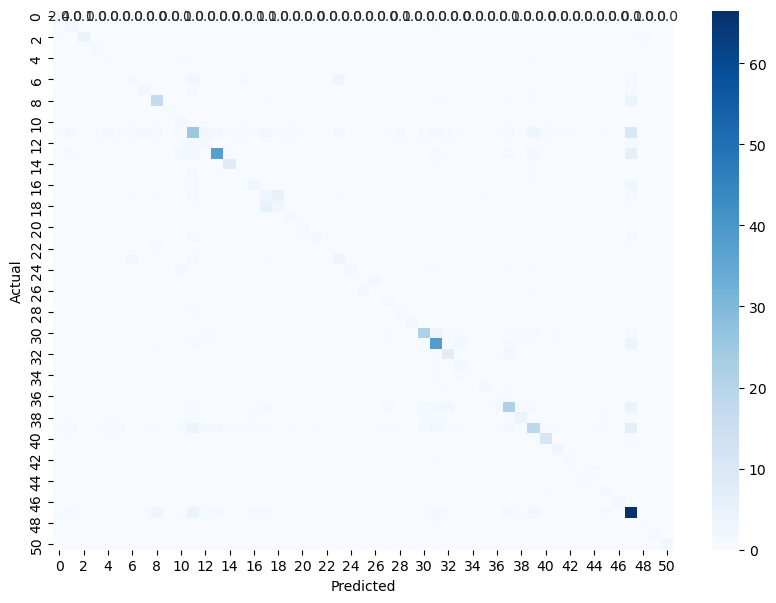

Random Forest CV accuracy=0.492 0.015
Random Forest CV AUC-ROC=0.851 0.008
Random Forest CV f1=0.492 0.015
CPU times: total: 28min 45s
Wall time: 8min 14s


In [ ]:
%%time

acc, auc, f1s, cm_avg, class_mapping = kfold_eval_docs(rf, X_train, y_train)

print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Random Forest CV AUC-ROC={np.mean(auc):.3f} {np.std(auc):.3f}')
print(f'Random Forest CV f1={np.mean(f1s):.3f} {np.std(f1s):.3f}')

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
ypred = rf.predict(X_test)
ypred_proba = rf.predict_proba(X_test)
testAcc = accuracy_score(y_test, ypred)
testAUC = roc_auc_score(y_test, ypred_proba, multi_class='ovr', average='weighted')
testF1 = f1_score(y_test, ypred, average='weighted')
testCMS = confusion_matrix(y_test, ypred)

In [ ]:
print(f'Random Forest Test accuracy={testAcc:.3f}')
print(f'Random Forest Test AUC-ROC={testAUC:.3f}')
print(f'Random Forest Test f1={testF1:.3f}')

Random Forest Test accuracy=0.467
Random Forest Test AUC-ROC=0.846
Random Forest Test f1=0.467


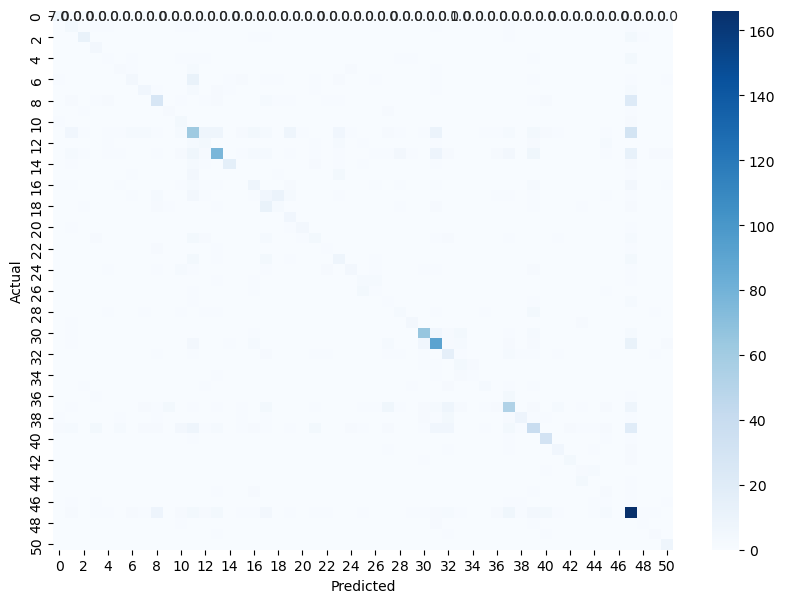

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(testCMS, annot=True, fmt=".1f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Checking if Accuracy is proportional to class size

C:\Users\Yahya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


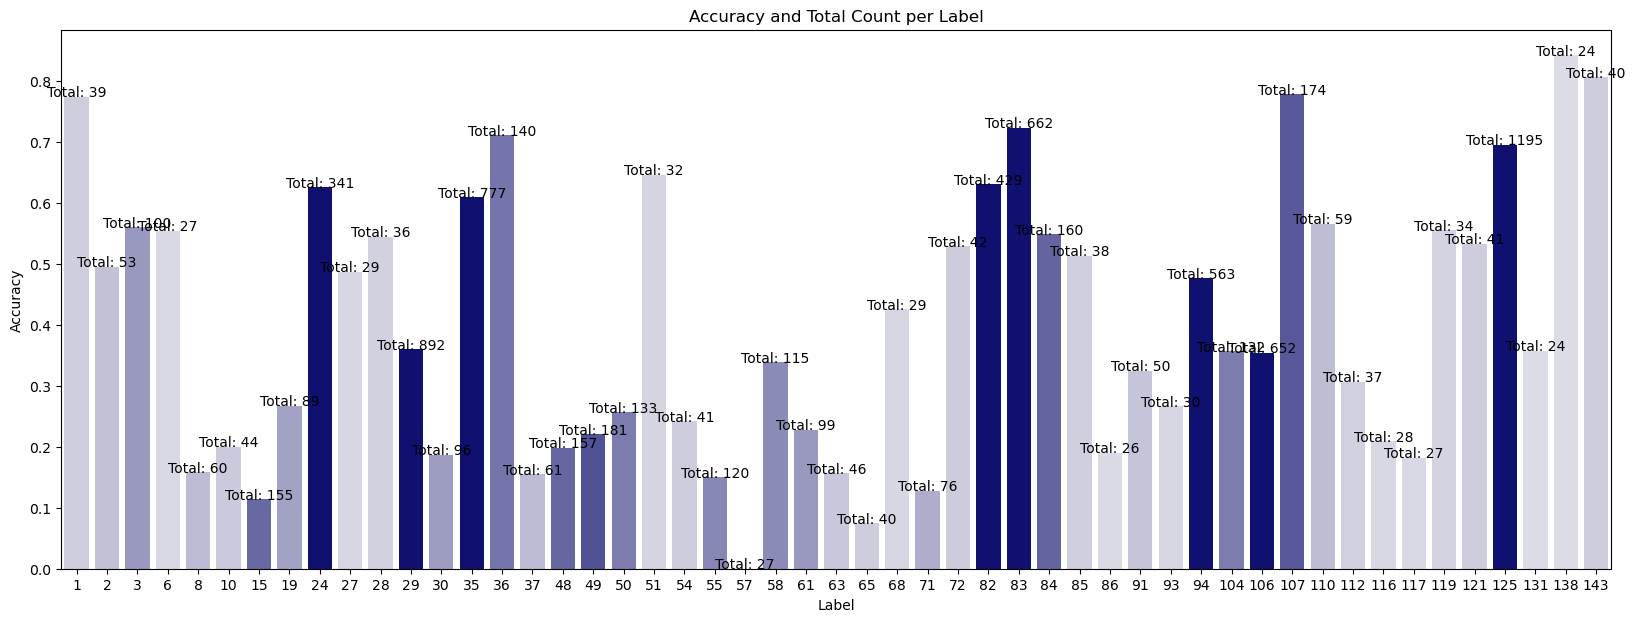

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


accLabel = {}
for j in range(len(cm_avg)):
    row_sum = np.sum(cm_avg[j,])
    if row_sum != 0:
        accuracy = cm_avg[j,j] / row_sum
    else:
        accuracy = 0
    original_label = class_mapping[j]
    accLabel[original_label] = {"accuracy": accuracy, "total": counts[original_label]}

labels = list(accLabel.keys())
accuracies = [accLabel[label]["accuracy"] for label in labels]
totals = [accLabel[label]["total"] for label in labels]

#Create a color map based on the totals
cmap = sns.light_palette("navy", as_cmap=True)
colors = cmap(totals)

fig, ax = plt.subplots(figsize=(20,7))

#Create the bar plot
sns.barplot(x=labels, y=accuracies, palette=colors, ax=ax)

#add the totals as text on each bar
for i, total in enumerate(totals):
    ax.text(i, accuracies[i], f'Total: {total}', ha='center')

plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.title('Accuracy and Total Count per Label')
plt.show()

** It appears that it is not that impacted, which makes the results here acceptable. This is expected as Ensemble methods are typically less prone to class imbalance than single classifier models. We will accept these results as our benchmark, and aim for methods that improve on teh performance **

# Applying GCN to improve the precision and recall of our model: Strategy

Obviously, as you are familiar with the current state of the dataset, even with feature selection reduction, our problem still retains a dimensionality of nearly 2000 genes.

This acts as a barrier to entry for any graph neural network problem, making training, testing, and evaluation take prohibitively long.

Also, gene to gene interactions are rather sparse, a gene may not have its interacting neighbor invoked by the publication. We would hardly have many non-disconnected graphs to work with.





#### Instead, we hypothesize that this problem can be reduced down to a pathway level characterization. That is, each gene invokes a set of pathways in which it belongs to. Other genes in a publication reinforce that pathway connection. To refrain from overly dense graphs, we only retain pathways that are reinforced by other genes in said publication.

Effectively we limit our feature space from 2000+ significant genes into ~350 pathways characterized by KEGG. Every pathway is a node, this node feature space is easily categorizeable as we will see. An edge represents a pathway connection to another pathway, this connection is ofcourse created by a gene.


To demonstrate this approach let's follow the following thought experiment, and I will create some visualizations to display these graphs.

Consider three genes for simplicity that only belong in a publication, Gene A, B, C.


Gene A:{ S, T, U, V, H, Z}, Gene B: { S, T, V, Q, R, S}, Gene C: {S, Q, R}


1. We start by creating all unique nodes in the graphs using a set: { S, T, U, V, H, Q, R, Z}
2. Then we create a count dictionary such that only pathways that are reinforced are retained : {S: 2, T: 1, V: 1, R: 1}
3. Then we create nodes using this limited set of reinforced pathways { S, T, V, R}
4. Then we create edges between these pathways { S-T, S-V, S-R, T-V, T-R, V-R} (using indeces and their reverse in a PyTorch graph Data object)
5. Then based on the degree of edges on a node, from all previously mentioned nodes, we can add a node feature that resembles its importance as a hub Pathway. (This increases the information packed inside the graph) {S: 8, V:7, Q: 4, R: 4, T: 7, U: 5, Z:5, H: 5} but only retain {S:8, T:7, V:7, R:4}
6. Finally we can also add another feature that resembles pathway reinforcement to linked pathwys in the resultant graph. {S:2, T: 1, V: 1, R: 1}




# Building the Graphs

We will need the gene data and we will use the gene names to pass it along to our KG database and recover the pathway names.

**The nice thing with this approach is that we don't have to throughout any data, as our genes will still be contained inside a limited set of pathways.**

In [ ]:
import pandas as pd

# Replace 'file.csv' with your csv file path
df = pd.read_csv('.\Documents\geneDataframe_significant.csv')

# Now 'df' is a DataFrame. You can view the first few rows with df.head()
print(df.head())
print(df.shape)

   RELA  DES  FTL  LGALS1  MEG3  MEST  TUBB  STMN1  EGFR  MDK  ...  CNBP  \
0     0    0    0       0     2     0     0      0     0    0  ...     0   
1     0    0    0       0     0     0     0      0     0    0  ...     0   
2     0    1    0       0     0     0     0      0     0    0  ...     0   
3     0    0    0       0     0     0     0      0     0    0  ...     0   
4     0    0    0       0     0     0     0      0     1    0  ...     0   

   ARMC12  ARMCX3  NTSR2  GSK1  NPW  ZCCHC8  CLIP1  FXYD1  PAMR1  
0       0       0      0     0    0       0      0      0      0  
1       0       0      0     0    0       0      0      0      0  
2       0       0      0     0    0       0      0      0      0  
3       0       0      0     0    0       0      0      0      0  
4       0       0      0     0    0       0      0      0      0  

[5 rows x 9043 columns]
(8502, 9043)


In [ ]:
counts = df['label'].value_counts()
sig_labels = counts[counts>20].index.tolist()
len(sig_labels)

51

*Now we need to create a map that readjusts class labels, previously they were Label numerically encoded, but as we cleaned the dataframe, the order of the labels was messed up. Here we need to readjust that order so that it ranges from 0 to n where n is the number of classes in our dataset.*

In [ ]:
yMap = {}
for i in range(len(sig_labels)):
    yMap[sig_labels[i]] = i

In [ ]:
list(yMap.items())[0:5]

[(125, 0), (29, 1), (35, 2), (83, 3), (106, 4)]

### Retrieving all pathway names

In [ ]:
import os

os.environ['NEO4J_URL'] = "bolt://localhost:7687"
os.environ['NEO4J_USR'] = "neo4j"
os.environ['NEO4J_PWD'] = "458458Yoyo"

url = os.environ['NEO4J_URL']
username = os.environ['NEO4J_USR']
password = os.environ['NEO4J_PWD']

In [ ]:
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(
    url=url,
    username=username,
    password=password
)

In [ ]:
allPathways = graph.query(f"""
MATCH (p:Pathway)
WITH p.name AS PathwayName
ORDER BY PathwayName
WITH collect(PathwayName) AS PathwayNames
RETURN PathwayNames
""")


In [ ]:
pathwayNames = allPathways[0]['PathwayNames']
filteredPathwayNames = [name for name in pathwayNames if not name.isupper()]

print(filteredPathwayNames[0:10])
print(len(filteredPathwayNames))

['Cellular Processes-Cell growth and death-Apoptosis', 'Cellular Processes-Cell growth and death-Apoptosis - multiple species', 'Cellular Processes-Cell growth and death-Cell cycle', 'Cellular Processes-Cell growth and death-Cellular senescence', 'Cellular Processes-Cell growth and death-Ferroptosis', 'Cellular Processes-Cell growth and death-Necroptosis', 'Cellular Processes-Cell growth and death-Oocyte meiosis', 'Cellular Processes-Cell growth and death-p53 signaling pathway', 'Cellular Processes-Cell motility-Motor proteins', 'Cellular Processes-Cell motility-Regulation of actin cytoskeleton']
356


In [ ]:
### We create a pathway map so that we can numerically encode each pathway

pathwayMap = {}
for i in range(len(filteredPathwayNames)):
    pathwayMap[filteredPathwayNames[i]] = i

print(list(pathwayMap.items())[0:5])

[('Cellular Processes-Cell growth and death-Apoptosis', 0), ('Cellular Processes-Cell growth and death-Apoptosis - multiple species', 1), ('Cellular Processes-Cell growth and death-Cell cycle', 2), ('Cellular Processes-Cell growth and death-Cellular senescence', 3), ('Cellular Processes-Cell growth and death-Ferroptosis', 4)]


## Encoding: Node Pathway Name features

#### By using a Binary Encoder, we can represent each pathway from a set of 350 pathways using an array of 9 elements.

**This is the best technique for the following problem, as numerical introduces ordinality, hash encoding is one-way, and standard dummy Encoding will produce an array of 356 dimensions which will make other features less significant.**

In [ ]:
import pandas as pd
import category_encoders as ce

# Convert your array into a DataFrame
df = pd.DataFrame(filteredPathwayNames, columns=['Feature'])

# Initialize the BinaryEncoder
encoder = ce.BinaryEncoder(cols=['Feature'])

# Fit and transform your features
df_binary = encoder.fit_transform(df['Feature'])
df_binary

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
351,1,0,1,1,0,0,0,0,0
352,1,0,1,1,0,0,0,0,1
353,1,0,1,1,0,0,0,1,0
354,1,0,1,1,0,0,0,1,1


**This binary Map allows us to index a binary representation of a pathway name simply by using its numerical encoding from pathwayMap.**


Ex)
pathwayMap['PathwayName'] = 0 numerical encoding; 0 numerical encoding 0th element from the binary Map = [0,0,0,0,0,0,0,0,1]

In [ ]:
binaryMap = df_binary.values.tolist()
binaryMap[0:3]

[[0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1]]

In [ ]:
X = dfComp.drop('label', axis=1)
y = dfComp['label']

## Graph Building functions

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from collections import Counter


def retrievePathways(geneNameList):

    resultPath = graph.query(f"""
    UNWIND {geneNameList} as geneName
    MATCH (g:Genes)-[t:belongs_to]->(p:Pathway)
    WHERE g.name = geneName
    WITH g, collect(p.name) as pathwayNames
    RETURN g.name, pathwayNames""")

    return resultPath

def visualize_graph(G):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), with_labels=False, node_size=6)
    plt.show()

def degreeDetect(node, allPath):
    print(node)
    print(allPath)
    return

def occupyMatrix(ground_truth, result):
    yVal = yMap[ground_truth]
    pathName = [ path for res in result for path in res['pathwayNames']]
    pathSet= set(pathName)

    count_dict = Counter(pathName)
    path_dict = {}
    for key, val in count_dict.items():
        if val > 1:
            path_dict[key] = val - 1


    nodeList = []
    for node in pathSet:
        if node in pathwayMap.keys() and node in path_dict.keys():
            pathInd = pathwayMap[node] #pathwayIndex
            binaryPath = binaryMap[pathInd][:] #binary Pathway representation
            nodeList.append(binaryPath)



    edgeList = []
    for res in result: #This way it has a gene-centric way to build the network (gene 1 pathways don't intersect with gene 2 unless specified by gene2)
        # only create edges between paths that are invoked
        pathways = [ path for path in res['pathwayNames'] if path in pathwayMap.keys() and path in path_dict.keys()]
        # print(pathways)
        for i in pathways:
            for j in pathways:
                if i != j:
                    # stores the index of the nodes
                    edgePair = [nodeList.index(binaryMap[pathwayMap[i]]), nodeList.index(binaryMap[pathwayMap[j]])]
                    if edgePair not in edgeList:
                        edgeList.append(edgePair)

    # iterating through the nodeInd and the edges that produced them
    for nodeInd in range(len(nodeList)):
        degree = 0
        binaryVector = nodeList[nodeInd]
        for edge in edgeList:
            if nodeInd==edge[0]:
                degree+=1
        pathIndex = binaryMap.index(binaryVector)
        nodeList[nodeInd].append(degree)
        # I have a dictionary with the pathway names as keys and the count as value.
        # I want to use the nodeInd, from the nodeInd get the pathway name, nodeList[i] contains binary representations, these are taken from pathwayMap
        #which are in the same index position as filterePathwayNames

        nodeList[nodeInd].append(path_dict[filteredPathwayNames[pathIndex]])


    nodes = torch.tensor(nodeList, dtype=torch.float)
    edges = torch.tensor(edgeList, dtype=torch.long)

    y = torch.tensor([yVal], dtype=torch.long)

    data = Data(x=nodes, edge_index = edges.t().contiguous(), y=y)

    return data

## Building the graphs and retaining information on disconnected graphs and empty graphs

In [ ]:
import time
from torch_geometric.data import Data, DataLoader
import torch_geometric
from scipy.sparse.csgraph import connected_components


empty_graphs = 0
disconnected_graphs = 0
pre_processed_graphs = []
disconnect_Connect = []

count= 0
for rowInd in range(X.shape[0]):
    time.sleep(0.1)
    count+=1
    rowEntry = X.iloc[rowInd]
    genes = rowEntry[ rowEntry > 0].index.tolist() #get all genes that are actually present in the pub
    resultPathways = retrievePathways(genes)
    data_pub = occupyMatrix(y[rowInd], resultPathways)
    if data_pub.num_nodes == 0 or data_pub.num_edges == 0:
        empty_graphs += 1
    else:
        # Convert edge_index to a scipy csr matrix
        edge_index_csr = torch_geometric.utils.to_scipy_sparse_matrix(data_pub.edge_index)
        # Get the number of connected components
        n_components, _ = connected_components(edge_index_csr)
        if n_components > 1:
            disconnected_graphs += 1
            disconnect_Connect.append(data_pub)
        else:
            # G = to_networkx(data_pub, to_undirected=True)
            # visualize_graph(G)
            pre_processed_graphs.append(data_pub)

    if count%1000==0:
        print(count)

### Saving graph array

In [ ]:
import pickle

# Save the data_list to a file
with open('./Documents/pathwayGNN/PathwayGNN_reduced_processed_dataset.pkl', 'wb') as f:
    pickle.dump(pre_processed_graphs, f)


In [ ]:
from torch_geometric.data import Data, DataLoader
import pickle
# Load the data_list from a file
with open('./Documents/pathwayGNN/PathwayGNN_reduced_processed_dataset.pkl', 'rb') as f:
    data_list = pickle.load(f)


### Familiarizing ourself with a graph data object

In [ ]:
data_list[0].x

tensor([[  0.,   0.,   1.,  ...,   0., 105.,   3.],
        [  0.,   1.,   0.,  ...,   0.,  59.,   2.],
        [  0.,   1.,   0.,  ...,   1., 102.,   1.],
        ...,
        [  0.,   0.,   1.,  ...,   1.,  98.,   3.],
        [  1.,   0.,   0.,  ...,   1., 100.,   2.],
        [  0.,   0.,   1.,  ...,   1.,  87.,   2.]])

In [ ]:
data_list[0].edge_index

tensor([[89, 89, 89,  ..., 72, 17, 18],
        [42, 39, 99,  ..., 18, 72, 72]])

In [ ]:
data_list[0].y

tensor([31])

In [ ]:
import pandas as pd

summary = pd.DataFrame(
    [(g.x.shape[0], g.edge_index.shape[1]/2) for g in data_list],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,3892.0,3892.0
mean,30.7,591.2
std,27.4,905.3
min,2.0,1.0
25%,7.0,18.0
50%,24.0,210.0
75%,48.0,836.0
max,225.0,13471.0


In [ ]:
data_list[7].x.shape

torch.Size([23, 11])

In [ ]:
def visualize_graph(G, data):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    # Create a dictionary mapping each node binary to its numerical encoding
    labels = {i: binaryMap.index(list(node_label[0:-2].numpy().astype(int))) for i, node_label in enumerate(data.x)}

    nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), labels=labels, node_size=6)

    plt.show()

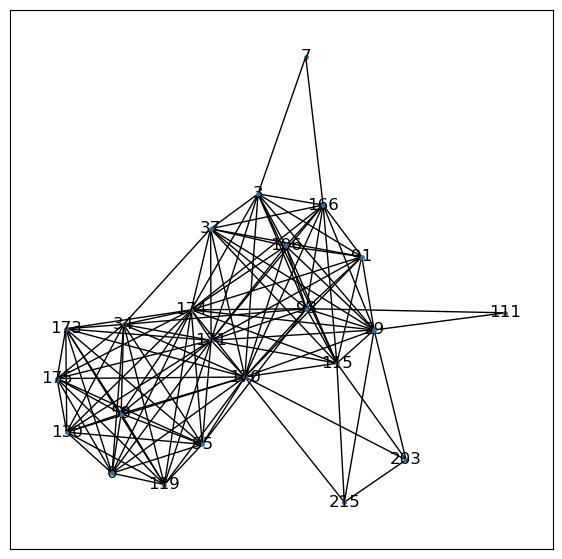

In [ ]:
G = to_networkx(data_list[7], to_undirected=True)
visualize_graph(G, data_list[7])

In [ ]:
data_list[7].edge_index.shape

torch.Size([2, 242])

### Let's visualize the rest of the graphs in this family

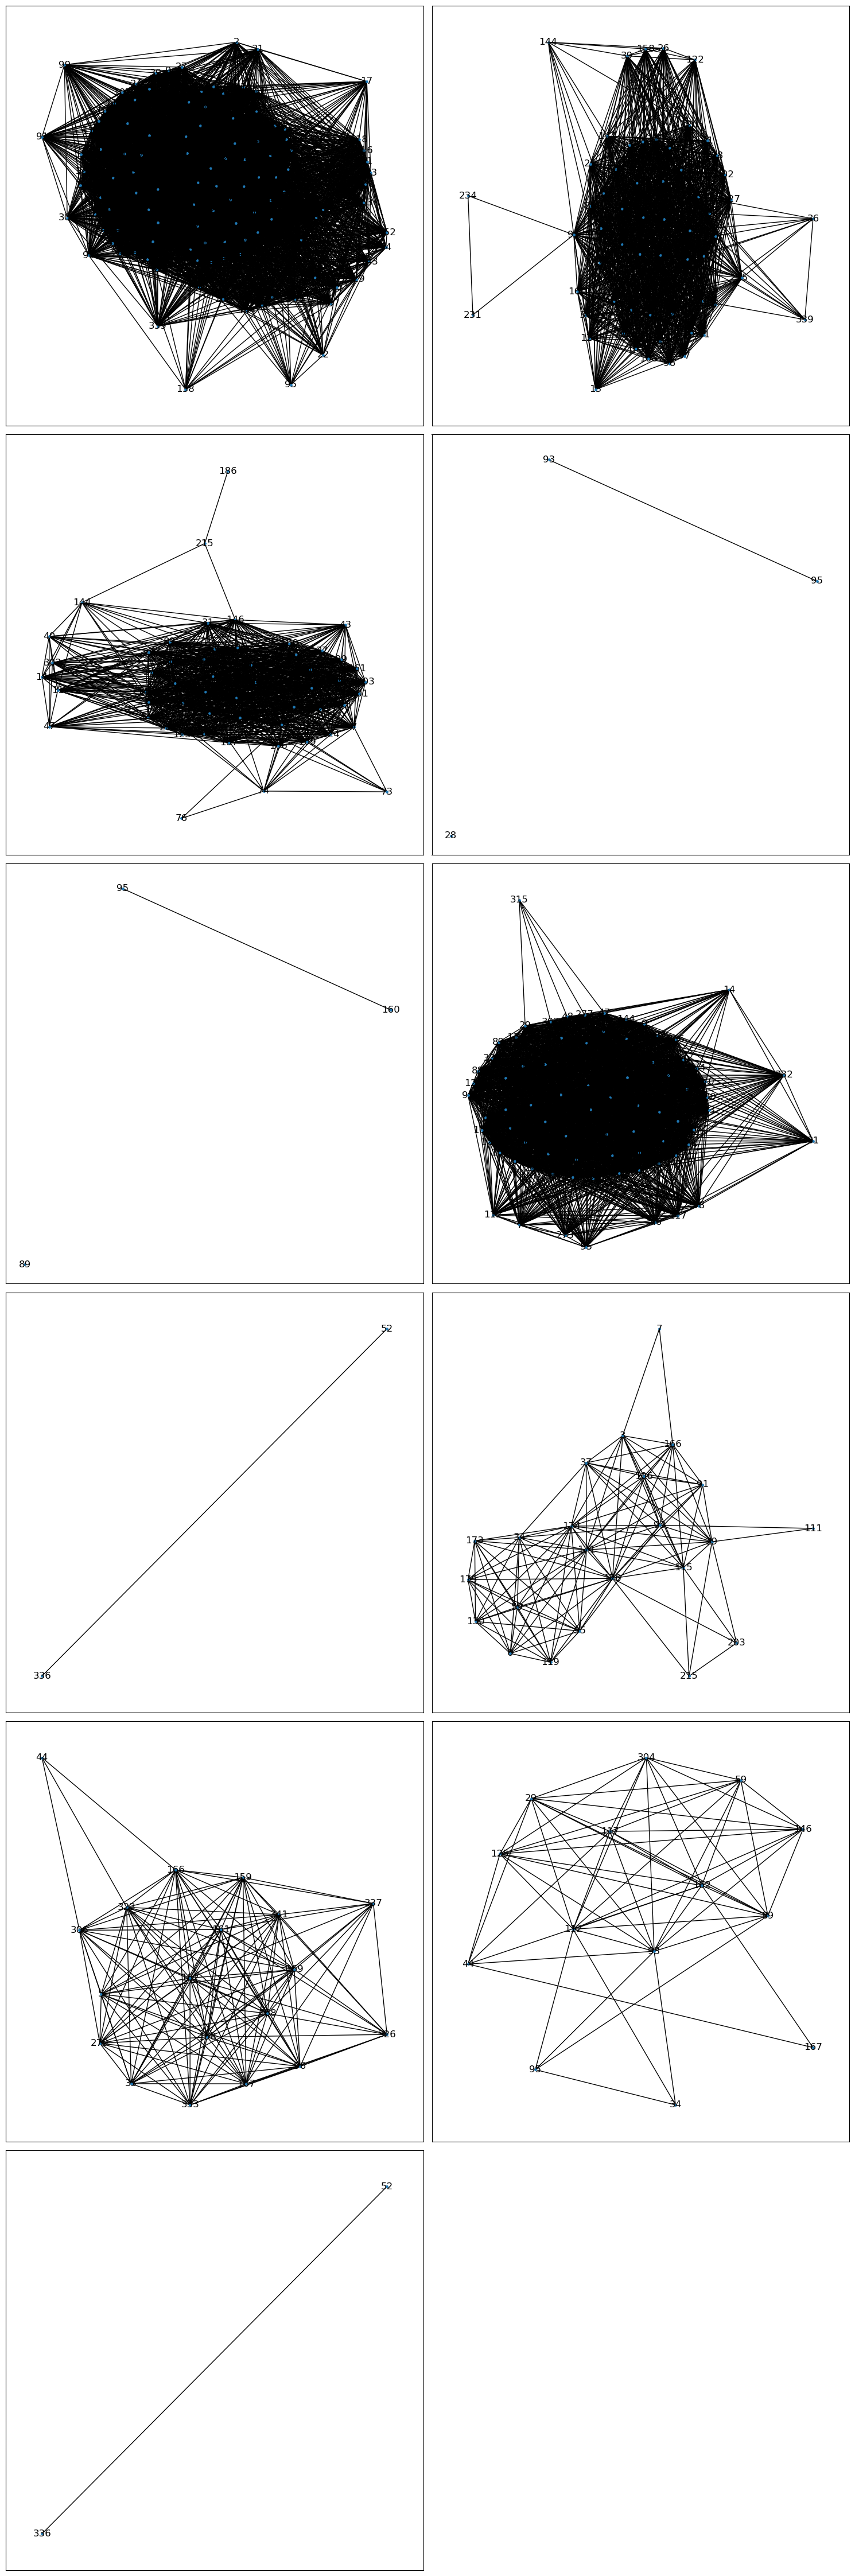

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import math

def visualize_graph(G, data, ax):
    # Create a dictionary mapping each node binary to its numerical encoding
    labels = {i: binaryMap.index(list(node_label[0:-2].numpy().astype(int))) for i, node_label in enumerate(data.x)}

    nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), labels=labels, node_size=6, ax=ax)

all_same = [i for i in range(len(data_list)) if data_list[i].y.item()==31]

# Calculate the number of rows and columns for the subplots
n = len(all_same)
ncols = 2
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*7.5))

for i, data_31 in enumerate(all_same):
    G = to_networkx(data_list[data_31], to_undirected=True)
    ax = axes[i//ncols, i%ncols] if nrows > 1 else (axes[i%ncols] if ncols > 1 else axes)
    visualize_graph(G, data_list[data_31], ax)

# Remove empty subplots
if n < nrows*ncols:
    for i in range(n, nrows*ncols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


# Standardization of node features

#### Since our data includes node features (the last 2) that are much larger than the binary encoded features, we can risk the possibility of the GCN model appraising these features higher. To prevent this, we conduct standardization on the node features.

In [ ]:
## Check
import torch

countNaN = 0
# Assume 'data_list' is your list of data objects
for data in data_list:
    # Check if there are any NaN values in the data
    if torch.isnan(data.x).any():
        # Handle NaN values. Here we replace NaN values with the mean of the other values in the same column.
        # You might want to use a different method to handle NaN values depending on your specific use case.
        countNaN += 1
print(countNaN)

0


In [ ]:
import torch

# Assume 'data_list' is your list of data objects
for data in data_list:
    # Calculate the mean and standard deviation for each column
    mean_1, std_1 = torch.mean(data.x[:, -2]), torch.std(data.x[:, -2])
    mean_2, std_2 = torch.mean(data.x[:, -1]), torch.std(data.x[:, -1])

    # Check if the standard deviation is zero
    if std_1 != 0:
        # If not, standardize the data
        data.x[:, -2] = (data.x[:, -2] - mean_1) / std_1
    else:
        # If standard deviation is zero, replace all values with the mean
        data.x[:, -2] = mean_1

    # Repeat the process for the second column
    if std_2 != 0:
        data.x[:, -1] = (data.x[:, -1] - mean_2) / std_2
    else:
        data.x[:, -1] = mean_2


In [ ]:
data_list[1].x[0:5]

tensor([[ 0.0000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000, -3.2744, -0.9178],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.1671, -0.2379],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  1.0000,
          1.0000, -0.8055, -0.9178],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.6160,  0.4419],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0923, -0.9178]])

# Correcting class imbalance through resampling

[31, 29, 14, 48, 33, 30, 22, 12, 17, 32, 28, 21, 42, 13, 7, 0, 16, 44, 2, 40, 50, 4, 38, 8, 45, 34, 26, 43, 1, 19, 24, 5, 47, 6, 36, 37, 41, 35, 23, 10, 20, 27, 46, 11, 3, 25, 9, 39, 15, 49, 18]
[11, 27, 66, 13, 24, 24, 42, 106, 68, 24, 25, 46, 11, 74, 154, 514, 67, 12, 356, 18, 14, 286, 11, 71, 11, 18, 24, 13, 390, 41, 18, 273, 15, 207, 17, 23, 16, 24, 35, 82, 34, 26, 8, 61, 277, 26, 61, 18, 60, 9, 41]


C:\Users\Yahya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


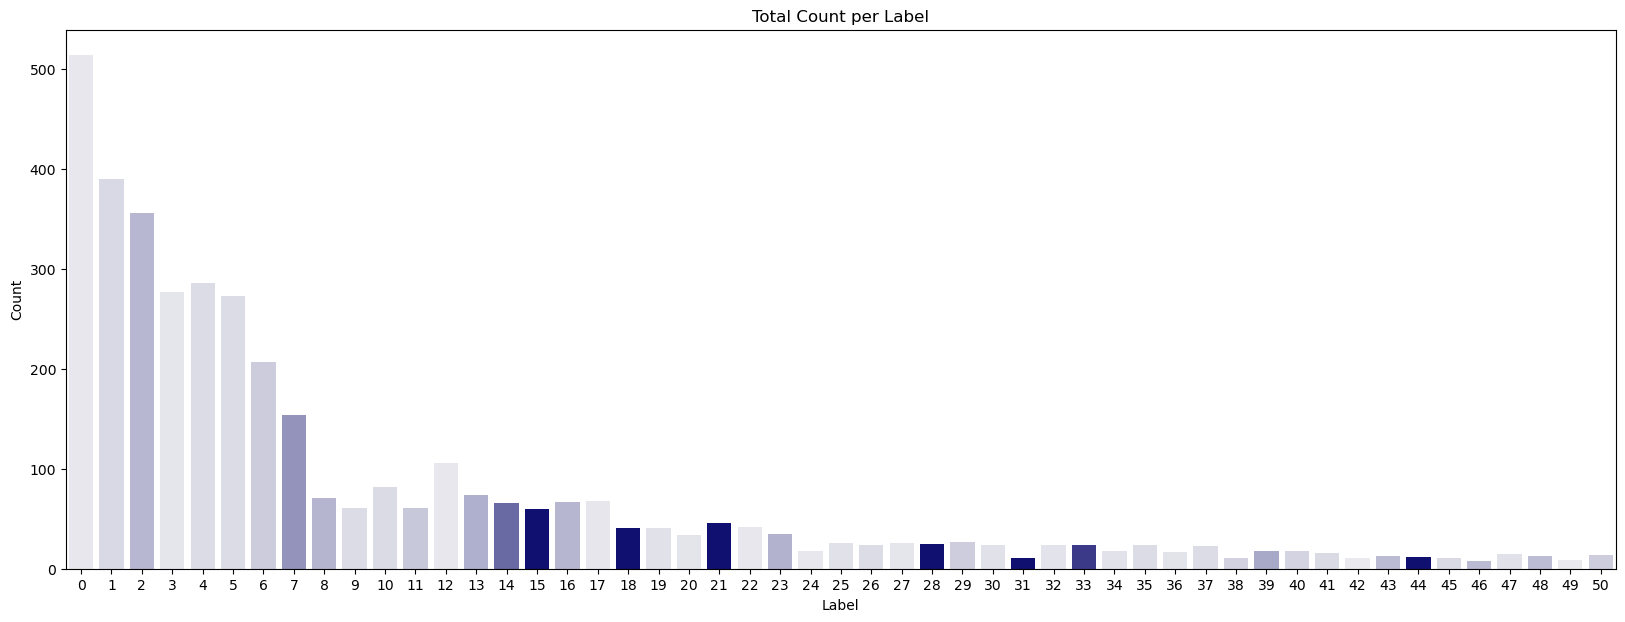

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


data_y = [data.y.item() for data in data_list]
labels = list(Counter(data_y).keys())
counts = list(Counter(data_y).values())
print(labels)
print(counts)


#Create a color map based on the totals
cmap = sns.light_palette("navy", as_cmap=True)
colors = cmap(counts)

fig, ax = plt.subplots(figsize=(20,7))

#Create the bar plot
sns.barplot(x=labels, y=counts, palette=colors, ax=ax)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Total Count per Label')
plt.show()

As you can see there is a stark imbalance in the dataset that needs readjustment, we can do this by either lowering the number of samples in the majority class (negatives is that our training data would be limited), or resample more data points from our minority classes (negatives: data variability, robustness of model, lower generalizeability, increased overfitting)

#### One way we can maintain variability while reducing overfitting is by eliminating extremely limited classes, while randomly resampling minority classes.

**We can also increase variability by randomly sampling minority classes: As in instead of creating copies of all graphs, we randomly pull copies from the available pool.**

**We pick the median class dataset size to recalibrate all minority classes to.**

**We also pick class sizes with a dataset greater than 15 graphs. This way at most we are introducing on average 4 copies of a graph.**

In [ ]:
classMedian = np.mean(counts)
print('Class Median', classMedian)
smallClassesIdx = [countIdx for countIdx in range(len(counts)) if counts[countIdx]<15]
print('Small Classes Index', smallClassesIdx)


smallClasses = [labels[labelIdx] for labelIdx in range(len(labels)) if labelIdx in smallClassesIdx]
print('Small Classes', smallClasses)

Class Median 76.31372549019608
Small Classes Index [0, 3, 12, 17, 20, 22, 24, 27, 42, 49]
Small Classes [31, 48, 42, 44, 50, 38, 45, 43, 46, 49]


In [ ]:
print(len(data_list))

data_list = [data for data in data_list if data.y.item() not in smallClasses]

print(len(data_list))

3892
3779


We only managed to omit 100 or so data points. Now we can actually balance the classes.

First though we need to relabel our points as the model needs a y value from 0 to class_num.

We can do this by first storing our old labels, and then adjusting our new ones.

In [ ]:
oldlabels = sorted(set([data.y.item() for data in data_list]))
print('oldlabels', oldlabels)
newlabelMap = {}
changedLabel = []
count = 0
for label in oldlabels:
    if label != count:
        newlabelMap[label] = count
        changedLabel.append(label)
        count += 1
        continue
    else:
        newlabelMap[label] = count
        count += 1

print('changedLabel', changedLabel)
print('newlabelMap', newlabelMap)

oldlabels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 47]
changedLabel [32, 33, 34, 35, 36, 37, 39, 40, 41, 47]
newlabelMap {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 39: 37, 40: 38, 41: 39, 47: 40}


In [ ]:
for data in data_list:
    if data.y.item() in changedLabel:
        data.y = torch.tensor([newlabelMap[data.y.item()]], dtype=torch.long)

[29, 14, 32, 30, 22, 12, 17, 31, 28, 21, 13, 7, 0, 16, 2, 38, 4, 8, 33, 26, 1, 19, 24, 5, 40, 6, 35, 36, 39, 34, 23, 10, 20, 27, 11, 3, 25, 9, 37, 15, 18]
[27, 66, 24, 24, 42, 106, 68, 24, 25, 46, 74, 154, 514, 67, 356, 18, 286, 71, 18, 24, 390, 41, 18, 273, 15, 207, 17, 23, 16, 24, 35, 82, 34, 26, 61, 277, 26, 61, 18, 60, 41]


C:\Users\Yahya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


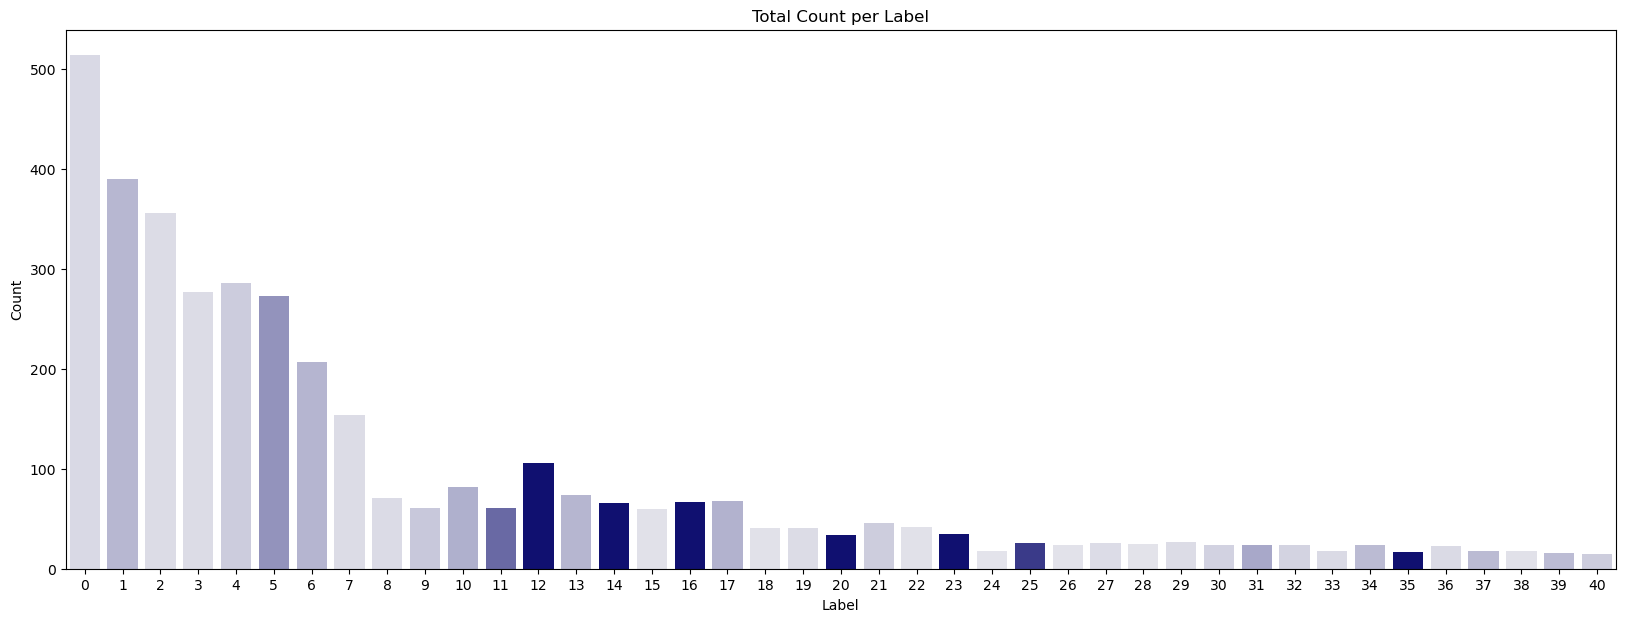

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


data_y = [data.y.item() for data in data_list]
labels = list(Counter(data_y).keys())
counts = list(Counter(data_y).values())
print(labels)
print(counts)


#Create a color map based on the totals
cmap = sns.light_palette("navy", as_cmap=True)
colors = cmap(counts)

fig, ax = plt.subplots(figsize=(20,7))

#Create the bar plot
sns.barplot(x=labels, y=counts, palette=colors, ax=ax)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Total Count per Label')
plt.show()

#### Now to resample:

In [ ]:
minorityClasses = [labels[countIdx] for countIdx in range(len(counts)) if counts[countIdx]<classMedian]
print(minorityClasses)
print(len(minorityClasses))

[29, 14, 32, 30, 22, 17, 31, 28, 21, 13, 16, 38, 8, 33, 26, 19, 24, 40, 35, 36, 39, 34, 23, 20, 27, 11, 25, 9, 37, 15, 18]
31


In [ ]:
#dictionary where each key is a label in the minorityClass,
# each label has a tuple as a value
# first item is an integer specifying the count
# second item is a list of indeces so that I can find where the data objects are in the data_set
# Iterate through the labels, append all data objects to a new list
# use the first item minus the median to determine the number of pulls, use a random number generator to get number of pulls
# pulls will be in indexes, generate a copy that is placed in the new array based on these pulls.
import numpy as np

rng = np.random.default_rng()
labelInfo = {}
new_list = []

for label in minorityClasses:
    count = 0
    idxList = []
    for dataIdx in range(len(data_list)):
        if data_list[dataIdx].y.item() == label:
            count += 1
            idxList.append(dataIdx)

    labelInfo[label] = (count, idxList)

for data in data_list:
    new_list.append(data)

In [ ]:
print('labelInfo', list(labelInfo.items())[:5])

labelInfo [(29, (27, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])), (14, (66, [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92])), (32, (24, [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116])), (30, (24, [117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140])), (22, (42, [141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]))]


In [ ]:
print(len(new_list))
print(len(data_list))
for label, values in labelInfo.items():
    countLabels, labelIdx = values
    duplicates = round(classMedian - countLabels)
    copyChosen = rng.choice(labelIdx, duplicates, replace=True)
    for idxCopy in copyChosen:
        new_list.append(new_list[idxCopy].clone())

print(len(new_list))

3779
3779
5001


In [ ]:
data_list = new_list

[29, 14, 32, 30, 22, 12, 17, 31, 28, 21, 13, 7, 0, 16, 2, 38, 4, 8, 33, 26, 1, 19, 24, 5, 40, 6, 35, 36, 39, 34, 23, 10, 20, 27, 11, 3, 25, 9, 37, 15, 18]
[76, 76, 76, 76, 76, 106, 76, 76, 76, 76, 76, 154, 514, 76, 356, 76, 286, 76, 76, 76, 390, 76, 76, 273, 76, 207, 76, 76, 76, 76, 76, 82, 76, 76, 76, 277, 76, 76, 76, 76, 76]


C:\Users\Yahya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


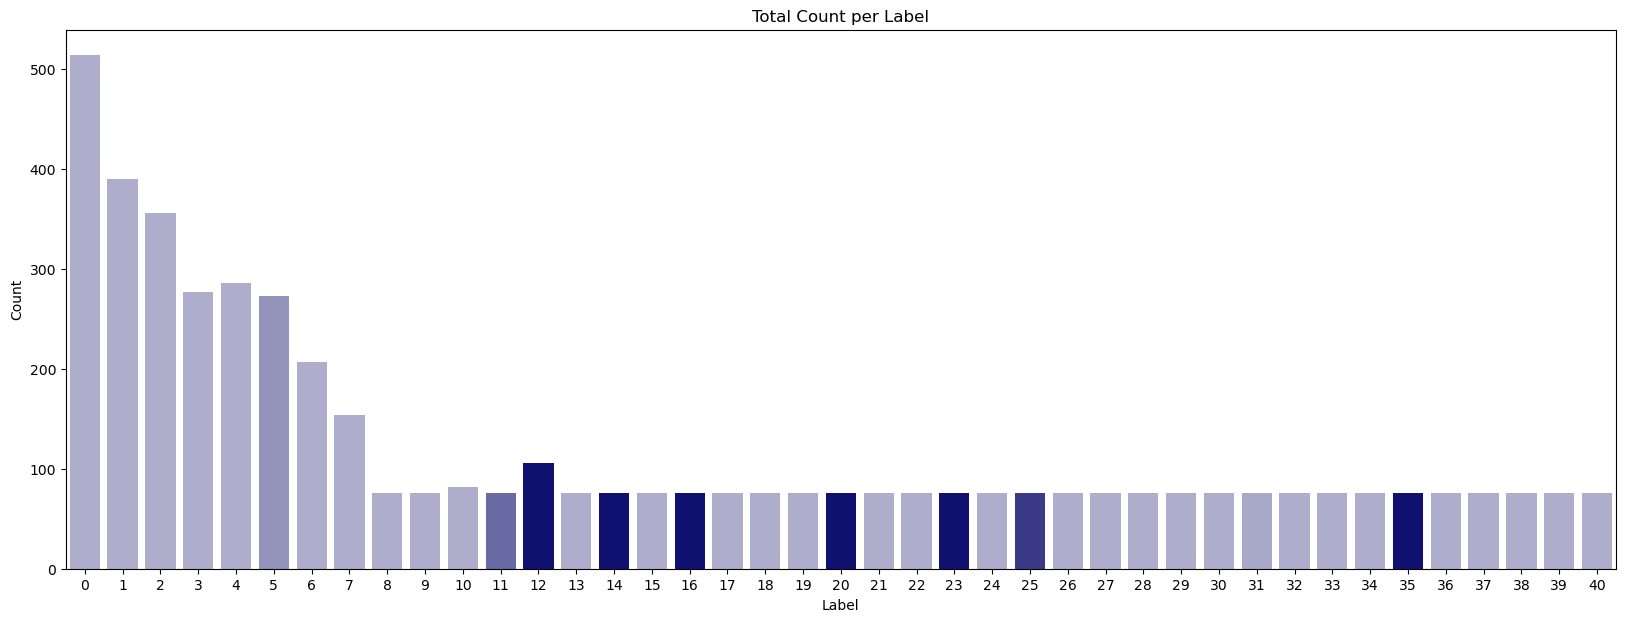

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


data_y = [data.y.item() for data in data_list]
labels = list(Counter(data_y).keys())
counts = list(Counter(data_y).values())
print(labels)
print(counts)


#Create a color map based on the totals
cmap = sns.light_palette("navy", as_cmap=True)
colors = cmap(counts)

fig, ax = plt.subplots(figsize=(20,7))

#Create the bar plot
sns.barplot(x=labels, y=counts, palette=colors, ax=ax)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Total Count per Label')
plt.show()

In [ ]:
import pickle

# Save the data_list to a file
with open('./PathwayGNN_resampled_dataset.pkl', 'wb') as f:
    pickle.dump(data_list, f)


# Model training First Attempt:
## Rebalanced Dataset, Model Parameters: 3GCN, 256Neurons, LR=0.001

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(11, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 41)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [ ]:
import time
from IPython.display import Javascript
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

model = GCN(hidden_channels=256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Create the figure and axis objects outside the function
fig, ax = plt.subplots(figsize=(10, 6))

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.


def test(loader):
     model.eval()
     all_preds = []
     all_labels = []
     all_preds_class = []

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         roc_pred = torch.nn.functional.softmax(out, dim=1) #Get predicted probability from logits.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         all_preds.extend(roc_pred.tolist())
         all_labels.extend(data.y.tolist())
         all_preds_class.extend(pred.tolist())

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.

     all_preds = np.array(all_preds)
     all_labels = np.array(all_labels)

      # Ensure all classes are represented in predictions
     for i in range(41):  # Assuming you have 51 classes
         if i not in all_labels:
             all_labels = np.append(all_labels, i)
             all_preds = np.append(all_preds, [np.full(41, 1e-3)], axis=0)
             all_preds[-1, i] = 1 - (40 * 1e-3)  # Small predicted probability for the missing class
             all_preds_class = np.append(all_preds_class, i)

     f1 = f1_score(all_labels, all_preds_class, average='weighted')

     return roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr'), correct / len(loader.dataset), f1  # Derive ratio of correct predictions.



skf = StratifiedKFold(n_splits=5)

#-----------------------Saving a portion of the dataset for testing on unseen data--------------------------------------------------

# Assuming `data` is your array of data objects
y = [item.y for item in data_list]  # Target variable (y attribute)


# Stratified split while keeping data objects intact
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=y)
y_train_data = [item.y for item in train_data]

print(f'Number of training graphs: {len(train_data)}')
print(f'Number of test graphs: {len(test_data)}')

fig, ax = plt.subplots()
lines = {}

train_f1_scores = []
valid_f1_scores = []

for fold, (train_index, valid_index) in enumerate(skf.split(train_data, y_train_data)):
    #Define early stopping parameters
    n_epochs_stop = 5
    min_val_f1 = -np.inf
    epochs_no_improve = 0

    print(len(train_index))
    # Split into training and testing data sets
    fold_train_data = [train_data[i] for i in train_index]
    fold_valid_data = [train_data[i] for i in valid_index]

    train_loader = DataLoader(fold_train_data, batch_size=32, shuffle=True)
    valid_loader = DataLoader(fold_valid_data, batch_size=32, shuffle=False)


    for epoch in range(1, 100):
        train()
        train_roc, train_acc, train_f1 = test(train_loader)
        test_roc, test_acc, test_f1= test(valid_loader)
        train_f1_scores.append(train_f1)
        valid_f1_scores.append(test_f1)

        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train ROC-AUC: {train_roc:.4f}, Test ROC-AUC: {test_roc:.4f}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')

        plot_f1_scores([train_f1_scores, valid_f1_scores])
        time.sleep(0.1)

        # Early stopping
        if epoch % 5 == 0:
            # Check if validation loss decreased
            if test_f1 > min_val_f1:
                # Save the model
                torch.save(model.state_dict(), 'best_model.pt')
                min_val_f1 = test_f1
            else:
                print('Hit no improve', epochs_no_improve)
                epochs_no_improve += 1
                # Check early stopping condition
                if epochs_no_improve == n_epochs_stop:
                    print('Early stopping!')
                    # Load best model weights
                    model.load_state_dict(torch.load('best_model.pt'))
                    break
    fold += 1

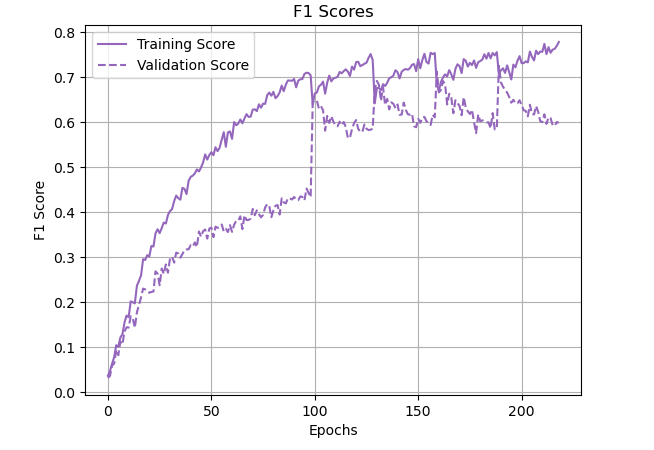

In [ ]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
fullTest_roc, fullTest_auc, fullTest_f1 = test(test_loader)
print(f'Test Acc: {fullTest_auc:.4f}, Test ROC-AUC: {fullTest_roc:.4f}, Test F1: {fullTest_f1:.4f}')

Test Acc: 0.4725, Test ROC-AUC: 0.8520, Test F1: 0.4671

#### The test result still indicates that the model is a bit overfitting to the training data.
#### Let's see if adding dropout regularization and weighted loss function helps with this.

# Adding dropout regularization and weighted loss function.

In [ ]:
print('labels', labels)
print('counts', counts)

total = sum(counts)

class_weights = []
for i in range(len(labels)):
    labelIdx = labels.index(i)
    count = counts[labelIdx]
    class_weights.append(count/total)

print('class_weights', class_weights)

labels [29, 14, 32, 30, 22, 12, 17, 31, 28, 21, 13, 7, 0, 16, 2, 38, 4, 8, 33, 26, 1, 19, 24, 5, 40, 6, 35, 36, 39, 34, 23, 10, 20, 27, 11, 3, 25, 9, 37, 15, 18]
counts [76, 76, 76, 76, 76, 106, 76, 76, 76, 76, 76, 154, 514, 76, 356, 76, 286, 76, 76, 76, 390, 76, 76, 273, 76, 207, 76, 76, 76, 76, 76, 82, 76, 76, 76, 277, 76, 76, 76, 76, 76]
class_weights [0.10277944411117776, 0.07798440311937613, 0.07118576284743051, 0.05538892221555689, 0.05718856228754249, 0.05458908218356329, 0.041391721655668866, 0.03079384123175365, 0.015196960607878424, 0.015196960607878424, 0.016396720655868825, 0.015196960607878424, 0.021195760847830435, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960607878424, 0.015196960

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(11, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(0.2)
        self.lin = Linear(hidden_channels, 41)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        x = self.dropout(x)
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [ ]:
import time
from IPython.display import Javascript
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score


def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.


def test(loader):
     model.eval()
     all_preds = []
     all_labels = []
     all_preds_class = []

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         roc_pred = torch.nn.functional.softmax(out, dim=1) #Get predicted probability from logits.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         all_preds.extend(roc_pred.tolist())
         all_labels.extend(data.y.tolist())
         all_preds_class.extend(pred.tolist())

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.

     all_preds = np.array(all_preds)
     all_labels = np.array(all_labels)

      # Ensure all classes are represented in predictions
     for i in range(41):  # Assuming you have 41 classes
         if i not in all_labels:
             all_labels = np.append(all_labels, i)
             all_preds = np.append(all_preds, [np.full(41, 1e-3)], axis=0)
             all_preds[-1, i] = 1 - (40 * 1e-3)  # Small predicted probability for the missing class
             all_preds_class = np.append(all_preds_class, i)

     f1 = f1_score(all_labels, all_preds_class, average='weighted')

     return roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr'), correct / len(loader.dataset), f1  # Derive ratio of correct predictions.



skf = StratifiedKFold(n_splits=5)

#-----------------------Saving a portion of the dataset for testing on unseen data--------------------------------------------------

# Assuming `data` is your array of data objects
y = [item.y for item in data_list]  # Target variable (y attribute)


# Stratified split while keeping data objects intact
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=y)
y_train_data = [item.y for item in train_data]

print(f'Number of training graphs: {len(train_data)}')
print(f'Number of test graphs: {len(test_data)}')

fig, ax = plt.subplots()
lines = {}

train_f1_scores = []
valid_f1_scores = []

for fold, (train_index, valid_index) in enumerate(skf.split(train_data, y_train_data)):
    #Define early stopping parameters
    n_epochs_stop = 5
    min_val_f1 = -np.inf
    epochs_no_improve = 0

    print(len(train_index))
    # Split into training and testing data sets
    fold_train_data = [train_data[i] for i in train_index]
    fold_valid_data = [train_data[i] for i in valid_index]

    train_loader = DataLoader(fold_train_data, batch_size=32, shuffle=True)
    valid_loader = DataLoader(fold_valid_data, batch_size=32, shuffle=False)


    for epoch in range(1, 100):
        train()
        train_roc, train_acc, train_f1 = test(train_loader)
        test_roc, test_acc, test_f1= test(valid_loader)
        train_f1_scores.append(train_f1)
        valid_f1_scores.append(test_f1)

        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train ROC-AUC: {train_roc:.4f}, Test ROC-AUC: {test_roc:.4f}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')

        plot_f1_scores([train_f1_scores, valid_f1_scores])
        time.sleep(0.1)

        # Early stopping
        if epoch % 5 == 0:
            # Check if validation loss decreased
            if test_f1 > min_val_f1:
                # Save the model
                torch.save(model.state_dict(), 'best_model.pt')
                min_val_f1 = test_f1
            else:
                print('Hit no improve', epochs_no_improve)
                epochs_no_improve += 1
                # Check early stopping condition
                if epochs_no_improve == n_epochs_stop:
                    print('Early stopping!')
                    # Load best model weights
                    model.load_state_dict(torch.load('best_model.pt'))
                    break
    fold += 1

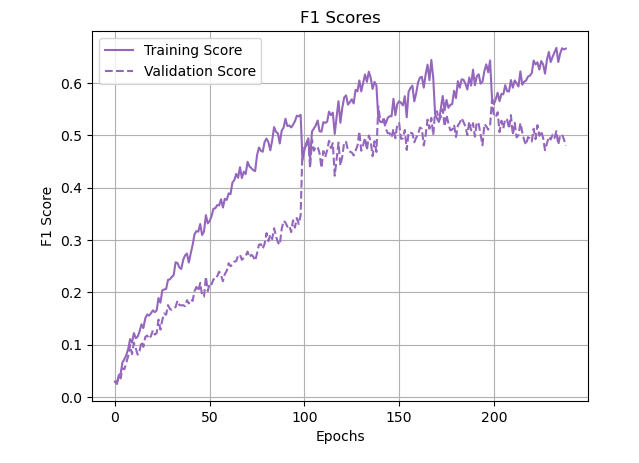

In [ ]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
fullTest_roc, fullTest_auc, fullTest_f1 = test(test_loader)
print(f'Test Acc: {fullTest_auc:.4f}, Test ROC-AUC: {fullTest_roc:.4f}, Test F1: {fullTest_f1:.4f}')

Test Acc: 0.3616, Test ROC-AUC: 0.8364, Test F1: 0.3431

# Full hyperparameter tunning:
### Checking best model size, number of conv layers, dropout rate, and learning rate.

1. Hidden Layers [128, 256, 512]
2. Depth of convolutional layers [2 convolutions, 3 convolutions, 4 convolutions]
3. Learning Rate [ 0.005, 0.001, 0.0005]
4. Dropout [0, 0.2, 0.5]

We will do this over an epoch of 30 and store key metrics into a dictionary.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


def plot_f1_scores(scores, model):
    """
    Plots the F1 scores for training and validation data.

    Parameters:
        scores (list of lists): A list containing two lists:
            - The first list contains the training scores for each epoch.
            - The second list contains the validation scores for each epoch.
    """
    # Unpack the scores
    training_scores, validation_scores = scores

    # Generate a color for the plot based on the fold number
    colors = plt.cm.tab10.colors
    color = colors[fold % len(colors)]

    # Clear the current plot only
    ax.clear()

    # Create the plot
    ax.plot(training_scores, label='Training Score', color=color)
    ax.plot(validation_scores, label='Validation Score', color=color, linestyle='--')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Scores {model}', fontsize=5)
    ax.legend()
    ax.grid(True)

    # Display the plot
    display(fig)
    clear_output(wait=True)

In [ ]:
# trainVal = { 'h64, d2, l0.01, d0.2' (64, 2, 0.01, 0.2): ([trainAcc, valAcc, trainROC, valROC, trainF1, valF1], [testAcc, testROC, testF1]) }



import time
from IPython.display import Javascript
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score


def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.


def test(loader):
     model.eval()
     all_preds = []
     all_labels = []
     all_preds_class = []

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         roc_pred = torch.nn.functional.softmax(out, dim=1) #Get predicted probability from logits.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         all_preds.extend(roc_pred.tolist())
         all_labels.extend(data.y.tolist())
         all_preds_class.extend(pred.tolist())

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.

     all_preds = np.array(all_preds)
     all_labels = np.array(all_labels)

      # Ensure all classes are represented in predictions
     for i in range(41):  # Assuming you have 41 classes
         if i not in all_labels:
             all_labels = np.append(all_labels, i)
             all_preds = np.append(all_preds, [np.full(41, 1e-3)], axis=0)
             all_preds[-1, i] = 1 - (40 * 1e-3)  # Small predicted probability for the missing class
             all_preds_class = np.append(all_preds_class, i)

     f1 = f1_score(all_labels, all_preds_class, average='weighted')

     return roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr'), correct / len(loader.dataset), f1  # Derive ratio of correct predictions.


In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, drop_out, depthConv):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(11, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(drop_out)
        self.lin = Linear(hidden_channels, 41)
        self.depth = depthConv

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        if self.depth == 2:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = self.dropout(x)
            x = self.conv2(x, edge_index)

            # 2. Readout layer
            x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

            # 3. Apply a final classifier
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.lin(x)
        elif self.depth==3:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = self.dropout(x)
            x = self.conv3(x, edge_index)

            # 2. Readout layer
            x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

            # 3. Apply a final classifier
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.lin(x)
        elif self.depth==4:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = self.dropout(x)
            x = self.conv3(x, edge_index)
            x = x.relu()
            x = self.dropout(x)
            x = self.conv4(x, edge_index)

            # 2. Readout layer
            x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

            # 3. Apply a final classifier
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.lin(x)

        return x

model = GCN(hidden_channels=256, drop_out=0, depthConv=3)
print(model)

In [ ]:
skf = StratifiedKFold(n_splits=4)

#-----------------------Saving a portion of the dataset for testing on unseen data--------------------------------------------------

# Assuming `data` is your array of data objects
y = [item.y for item in data_list]  # Target variable (y attribute)


# Stratified split while keeping data objects intact
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=y)
y_train_data = [item.y for item in train_data]

print(f'Number of training graphs: {len(train_data)}')
print(f'Number of test graphs: {len(test_data)}')

lines = {}

#-----------------------Doing Training--------------------------------------------------
hiddenLayers = [128, 256, 512]
depthOfConvolution = [2, 3, 4]
learningRate = [0.005, 0.001, 0.0005]
dropOut = [0, 0.2, 0.5]

In [ ]:
gridResults = {}

for hidden in hiddenLayers:
    for learning in learningRate:
        for dropout in dropOut:
            for depth in depthOfConvolution:
                model = GCN(hidden_channels=hidden, drop_out= dropout, depthConv=depth)
                print(model)
                weights = torch.tensor(class_weights, dtype=torch.float)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning)
                criterion = torch.nn.CrossEntropyLoss(weight = weights)

                # Create the figure and axis objects outside the function
                fig, ax = plt.subplots(figsize=(10, 6))

                train_f1_scores = []
                valid_f1_scores = []

                for fold, (train_index, valid_index) in enumerate(skf.split(train_data, y_train_data)):
                    #Define early stopping parameters
                    n_epochs_stop = 5
                    min_val_f1 = -np.inf
                    epochs_no_improve = 0

                    print(len(train_index))
                    # Split into training and testing data sets
                    fold_train_data = [train_data[i] for i in train_index]
                    fold_valid_data = [train_data[i] for i in valid_index]

                    train_loader = DataLoader(fold_train_data, batch_size=32, shuffle=True)
                    valid_loader = DataLoader(fold_valid_data, batch_size=32, shuffle=False)


                    for epoch in range(1, 30):
                        train()
                        train_roc, train_acc, train_f1 = test(train_loader)
                        val_roc, val_acc, val_f1= test(valid_loader)
                        train_f1_scores.append(train_f1)
                        valid_f1_scores.append(val_f1)

                        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train ROC-AUC: {train_roc:.4f}, Val ROC-AUC: {val_roc:.4f}, Train F1: {train_f1:.4f}, Test F1: {val_f1:.4f}')

                        plot_f1_scores([train_f1_scores, valid_f1_scores], model)
                        time.sleep(0.1)

                        # Early stopping
                        if epoch % 5 == 0:
                            # Check if validation loss decreased
                            if val_f1 > min_val_f1:
                                # Save the model
                                torch.save(model.state_dict(), 'best_model.pt')
                                min_val_f1 = val_f1
                            else:
                                print('Hit no improve', epochs_no_improve)
                                epochs_no_improve += 1
                                # Check early stopping condition
                                if epochs_no_improve == n_epochs_stop:
                                    print('Early stopping!')
                                    # Load best model weights
                                    model.load_state_dict(torch.load('best_model.pt'))
                                    break
                    fold += 1

                test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
                fullTest_roc, fullTest_auc, fullTest_f1 = test(test_loader)
                print(f'Test Acc: {fullTest_auc:.4f}, Test ROC-AUC: {fullTest_roc:.4f}, Test F1: {fullTest_f1:.4f}')

                # trainVal = { 'd2, h64, l0.01, d0.2' (64, 2, 0.01, 0.2): ([trainAcc, valAcc, trainROC, valROC, trainF1, valF1], [testAcc, testROC, testF1]) }
                gridResults[(depth, hidden, learning, dropout)] = ([train_acc, val_acc, train_roc, val_roc, train_f1, val_f1], [fullTest_roc, fullTest_auc, fullTest_f1])
                print('gridResults', gridResults)
                plt.savefig(f'./Documents/plot_{hidden}_{learning}_{dropout}_{depth}_{epoch}.png')


- Results are stored in gridResult dictionary in the following format:
  
**{ 'd2, h64, l0.01, d0.2' (64, 2, 0.01, 0.2): ([trainAcc, valAcc, trainROC, valROC, trainF1, valF1], [testAcc, testROC, testF1]) }**

### Identifying the best performing model:

In [ ]:
maxF1 = 0
maxParameters = {'convLayers':0, 'hiddenLayers':0, 'learningRate':0, 'dropOut':0}
for point in newgridResults.items():
    convLayers, hiddenLayers, learningRate, dropOut = point[0]
    testF1 = point[1][1][2]

    if testF1>maxF1:
        maxF1= testF1
        maxParameters['convLayers'] = convLayers
        maxParameters['hiddenLayers'] = hiddenLayers
        maxParameters['learningRate'] = learningRate
        maxParameters['dropOut'] = dropOut


print('maxF1', maxF1)
print('maxParameters', maxParameters)

maxF1 0.5164978789623222

maxParameters {'convLayers': 4, 'hiddenLayers': 512, 'learningRate': 0.001, 'dropOut': 0}

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for the plot
data = []
for point in newgridResults.items():
    convLayers, hiddenLayers, learningRate, dropOut = point[0]
    testF1 = point[1][1][2]
    data.append([convLayers, hiddenLayers, learningRate, dropOut, testF1])

# Convert data to a pandas DataFrame
df = pd.DataFrame(data, columns=['convLayers', 'hiddenLayers', 'learningRate', 'dropOut', 'testF1'])

# Create individual scatter plots for each pair of variables
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
columns = ['convLayers', 'hiddenLayers', 'learningRate', 'dropOut']

for i, column in enumerate(columns):
    # Plot all points in blue
    axs[i].scatter(df[column], df['testF1'], color='blue')
    # Highlight the point with the maximum 'testF1' value in yellow
    axs[i].scatter(df[column][df['testF1'].idxmax()], df['testF1'].max(), color='yellow')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('testF1')

# Show the plots
plt.tight_layout()
plt.show()


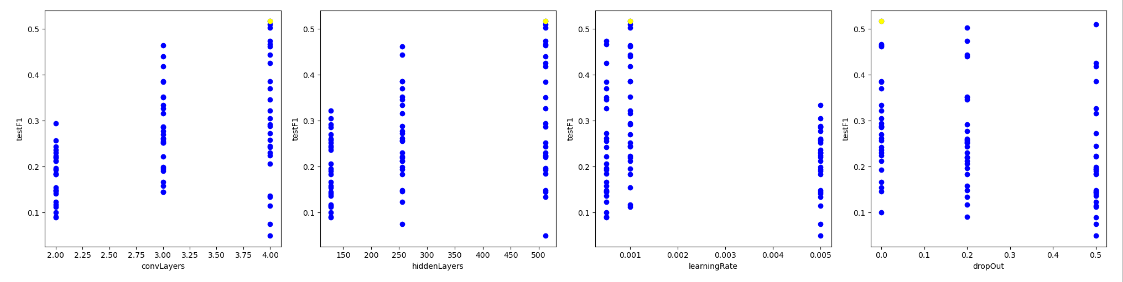


# Final Build with the optimal parameters

### 4 Conv Layers, Dropout of 0, Hidden Layers 512, Learning Rate of 0.001

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


def plot_f1_scores(scores):
    """
    Plots the F1 scores for training and validation data.

    Parameters:
        scores (list of lists): A list containing two lists:
            - The first list contains the training scores for each epoch.
            - The second list contains the validation scores for each epoch.
    """
    # Unpack the scores
    training_scores, validation_scores = scores

    # Generate a color for the plot based on the fold number
    colors = plt.cm.tab10.colors
    color = colors[fold % len(colors)]

    # Clear the current plot only
    ax.clear()

    # Create the plot
    ax.plot(training_scores, label='Training Score', color=color)
    ax.plot(validation_scores, label='Validation Score', color=color, linestyle='--')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Scores Best Model: 4Conv, 0.001LR, 512HL, 0DO', fontsize=5)
    ax.legend()
    ax.grid(True)

    # Display the plot
    display(fig)
    clear_output(wait=True)

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(11, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.lin = Linear(hidden_channels, 41)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        # x = self.conv3(x, edge_index)
        # x = x.relu()
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


In [ ]:
model = GCN(hidden_channels=512, dropout=0)
weights = torch.tensor(class_weights, dtype=torch.float)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight = weights)

In [ ]:
import time
from IPython.display import Javascript
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score


def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.


def test(loader):
     model.eval()
     all_preds = []
     all_labels = []
     all_preds_class = []

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         roc_pred = torch.nn.functional.softmax(out, dim=1) #Get predicted probability from logits.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         all_preds.extend(roc_pred.tolist())
         all_labels.extend(data.y.tolist())
         all_preds_class.extend(pred.tolist())

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.

     all_preds = np.array(all_preds)
     all_labels = np.array(all_labels)

      # Ensure all classes are represented in predictions
     for i in range(41):  # Assuming you have 41 classes
         if i not in all_labels:
             all_labels = np.append(all_labels, i)
             all_preds = np.append(all_preds, [np.full(41, 1e-3)], axis=0)
             all_preds[-1, i] = 1 - (40 * 1e-3)  # Small predicted probability for the missing class
             all_preds_class = np.append(all_preds_class, i)

     f1 = f1_score(all_labels, all_preds_class, average='weighted')

     return roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr'), correct / len(loader.dataset), f1  # Derive ratio of correct predictions.



skf = StratifiedKFold(n_splits=5)

#-----------------------Saving a portion of the dataset for testing on unseen data--------------------------------------------------

# Assuming `data` is your array of data objects
y = [item.y for item in data_list]  # Target variable (y attribute)


# Stratified split while keeping data objects intact
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=y)
y_train_data = [item.y for item in train_data]

print(f'Number of training graphs: {len(train_data)}')
print(f'Number of test graphs: {len(test_data)}')

fig, ax = plt.subplots()
lines = {}

train_f1_scores = []
valid_f1_scores = []

for fold, (train_index, valid_index) in enumerate(skf.split(train_data, y_train_data)):
    #Define early stopping parameters
    n_epochs_stop = 5
    min_val_f1 = -np.inf
    epochs_no_improve = 0

    print(len(train_index))
    # Split into training and testing data sets
    fold_train_data = [train_data[i] for i in train_index]
    fold_valid_data = [train_data[i] for i in valid_index]

    train_loader = DataLoader(fold_train_data, batch_size=32, shuffle=True)
    valid_loader = DataLoader(fold_valid_data, batch_size=32, shuffle=False)


    for epoch in range(1, 100):
        train()
        train_roc, train_acc, train_f1 = test(train_loader)
        test_roc, test_acc, test_f1= test(valid_loader)
        train_f1_scores.append(train_f1)
        valid_f1_scores.append(test_f1)

        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train ROC-AUC: {train_roc:.4f}, Test ROC-AUC: {test_roc:.4f}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')

        plot_f1_scores([train_f1_scores, valid_f1_scores])
        time.sleep(0.1)

        # Early stopping
        if epoch % 5 == 0:
            # Check if validation loss decreased
            if test_f1 > min_val_f1:
                # Save the model
                torch.save(model.state_dict(), 'best_model.pt')
                min_val_f1 = test_f1
            else:
                print('Hit no improve', epochs_no_improve)
                epochs_no_improve += 1
                # Check early stopping condition
                if epochs_no_improve == n_epochs_stop:
                    print('Early stopping!')
                    # Load best model weights
                    model.load_state_dict(torch.load('best_model.pt'))
                    break
    fold += 1

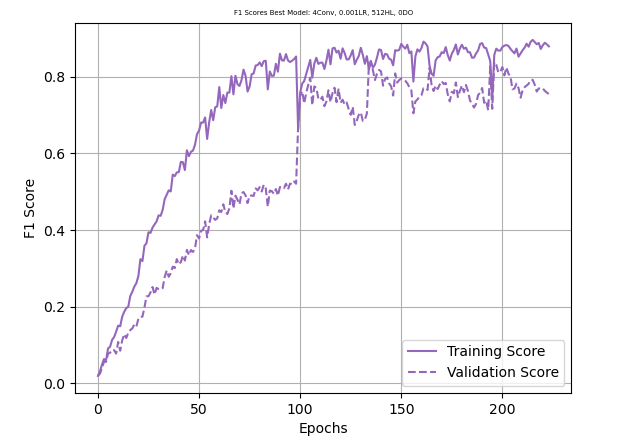

In [ ]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
fullTest_roc, fullTest_auc, fullTest_f1 = test(test_loader)
print(f'Test Acc: {fullTest_auc:.4f}, Test ROC-AUC: {fullTest_roc:.4f}, Test F1: {fullTest_f1:.4f}')

C:\Users\Yahya\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Test Acc: 0.5554, Test ROC-AUC: 0.8610, Test F1: 0.5546


Test Acc: 0.5544, Test ROC-AUC: 0.8667, Test F1: 0.5523

In [12]:
# Defining the model architecture
model = GCN(hidden_channels=512, dropout=0)

# Load the state dictionary
model.load_state_dict(torch.load('./best_model.pt'))

# Set the model in evaluation mode
model.eval()

GCN(
  (conv1): GCNConv(11, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 512)
  (conv4): GCNConv(512, 512)
  (dropout): Dropout(p=0, inplace=False)
  (lin): Linear(in_features=512, out_features=41, bias=True)
)

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

def test(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_preds_class = []

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        roc_pred = torch.nn.functional.softmax(out, dim=1) #Get predicted probability from logits.
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        all_preds.extend(roc_pred.tolist())
        all_labels.extend(data.y.tolist())
        all_preds_class.extend(pred.tolist())

        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Ensure all classes are represented in predictions
    for i in range(41):  # Assuming you have 41 classes
        if i not in all_labels:
            all_labels = np.append(all_labels, i)
            all_preds = np.append(all_preds, [np.full(41, 1e-3)], axis=0)
            all_preds[-1, i] = 1 - (40 * 1e-3)  # Small predicted probability for the missing class
            all_preds_class = np.append(all_preds_class, i)

    f1 = f1_score(all_labels, all_preds_class, average='weighted')

    # Generate the confusion matrix
    cms = confusion_matrix(all_labels, all_preds_class)

    return roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr'), correct / len(loader.dataset), f1, cms  # Derive ratio of correct predictions.


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pickle

# Load the data_list from a file
with open('/content/drive/MyDrive/Colab Notebooks/PathwayGNN_resampled_dataset.pkl', 'rb') as f:
  data_list = pickle.load(f)


In [25]:
from sklearn.model_selection import train_test_split

y = [item.y for item in data_list]  # Target variable (y attribute)
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=y)

In [31]:
from torch_geometric.data import Data, DataLoader


test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
fullTest_roc, fullTest_auc, fullTest_f1, cms = test(test_loader)
print(f'Test Acc: {fullTest_auc:.4f}, Test ROC-AUC: {fullTest_roc:.4f}, Test F1: {fullTest_f1:.4f}')

Test Acc: 0.5475, Test ROC-AUC: 0.8623, Test F1: 0.5468


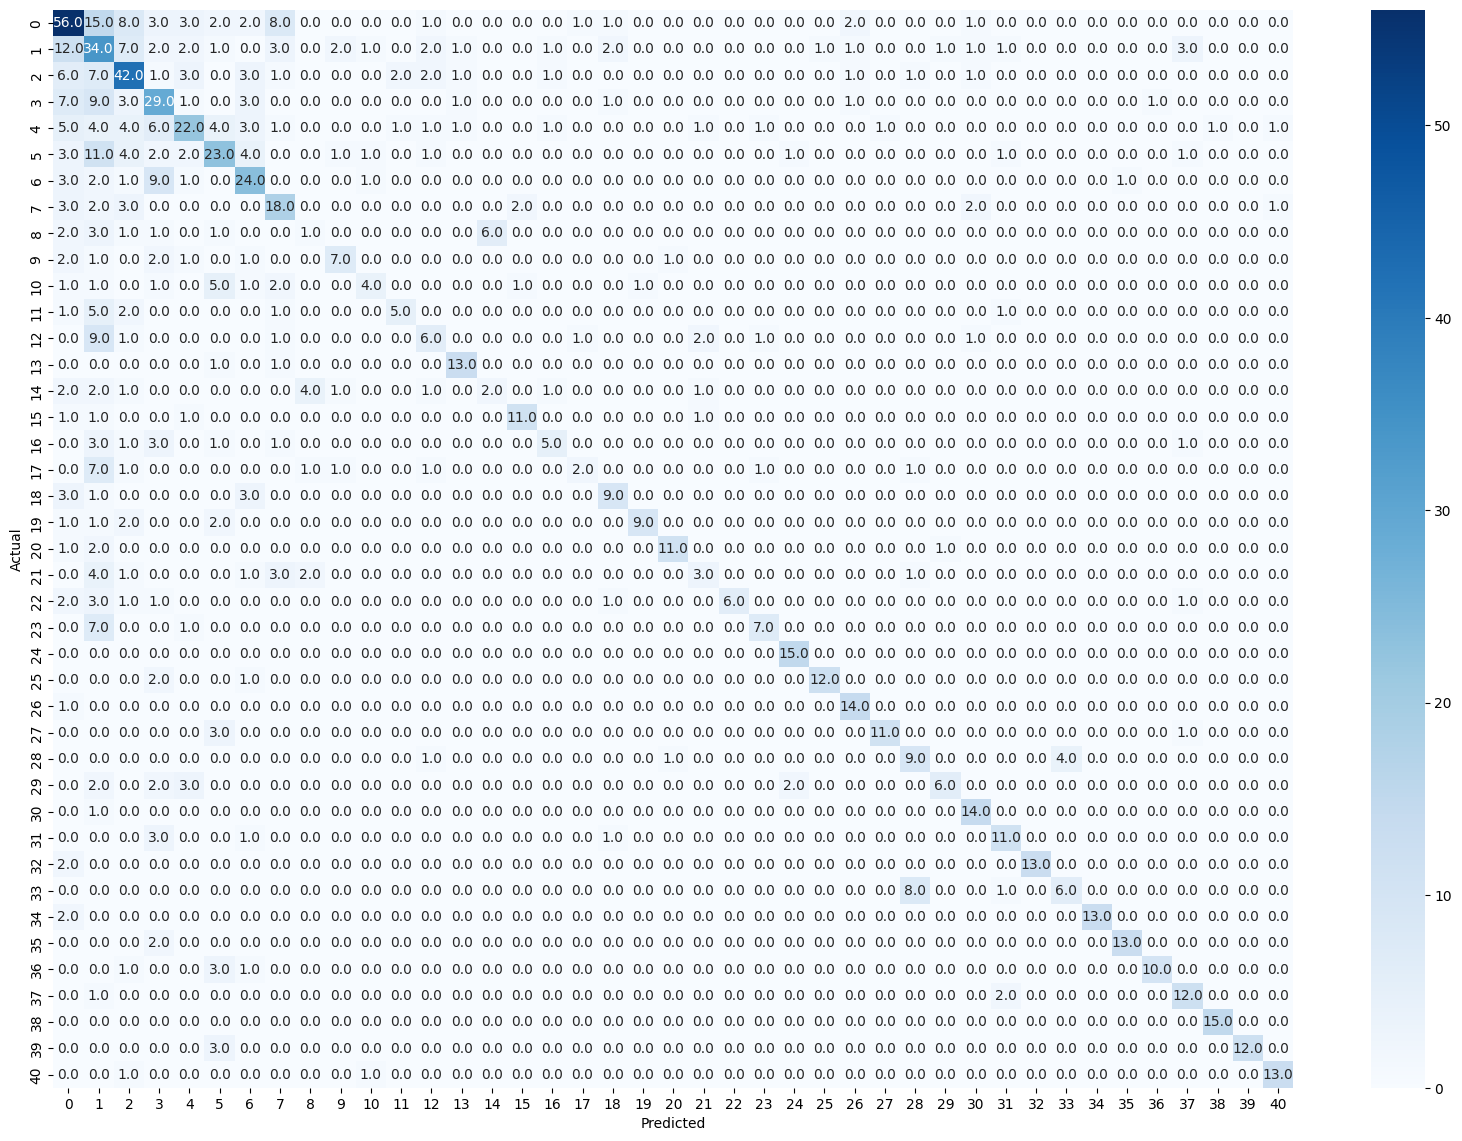

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,14))
sns.heatmap(cms, annot=True, fmt=".1f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

All classes seem to have improved from the random forest classifier. Still there are some classes that this model performed poorly in predicting, namely:
8, 12, 14, 17, 21, 33

In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

def test(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_preds_class = []
    all_features = []

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        all_features.extend(out.tolist())
        roc_pred = torch.nn.functional.softmax(out, dim=1) #Get predicted probability from logits.
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        all_preds.extend(roc_pred.tolist())
        all_labels.extend(data.y.tolist())
        all_preds_class.extend(pred.tolist())

        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_features = np.array(all_features)

    # Ensure all classes are represented in predictions
    for i in range(41):  # Assuming you have 41 classes
        if i not in all_labels:
            all_labels = np.append(all_labels, i)
            all_preds = np.append(all_preds, [np.full(41, 1e-3)], axis=0)
            all_preds[-1, i] = 1 - (40 * 1e-3)  # Small predicted probability for the missing class
            all_preds_class = np.append(all_preds_class, i)

    f1 = f1_score(all_labels, all_preds_class, average='weighted')

    # Generate the confusion matrix
    cms = confusion_matrix(all_labels, all_preds_class)

    return roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr'), correct / len(loader.dataset), f1, cms, all_features, all_labels  # Derive ratio of correct predictions.


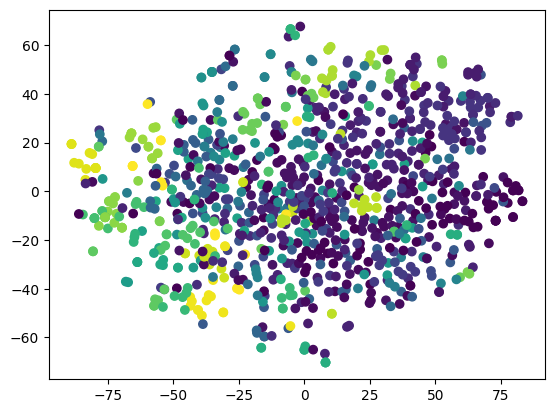

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run the test function and get the features
roc_auc, acc, f1, cms, features, all_labels = test(test_loader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Create a scatter plot
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels)
plt.show()


In [58]:
import plotly.graph_objects as go

# Assuming that 'all_labels' are integers starting from 0
unique_labels = np.unique(all_labels)
label_names = [f'Label {i}' for i in unique_labels]  # Replace with actual label names if available

# Create a trace for each label
traces = []
for label, name in zip(unique_labels, label_names):
    idx = np.where(all_labels == label)
    traces.append(
        go.Scatter(
            x=features_2d[idx, 0].ravel(),  # Flatten the array
            y=features_2d[idx, 1].ravel(),  # Flatten the array
            mode='markers',
            name=name,
            marker=dict(
                size=6,
                opacity=0.2  # Adjust as needed
            )
        )
    )

layout = go.Layout(
    title='t-SNE Plot',
    hovermode='closest',
    width=1600,  # Adjust as needed
    height=1200,  # Adjust as needed
    xaxis=dict(
        title='Component 1',
        ticklen=5,
        zeroline=False,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Component 2',
        ticklen=5,
        gridwidth=2,
    ),
    showlegend=True,
    legend=dict(
        itemclick='toggleothers',
        itemdoubleclick='toggle'
    ),
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{'marker.opacity': [1 if trace['name'] == name else 0.2 for trace in traces]}],
                    label=name,
                    method='restyle'
                ) for name in label_names
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ]
)

fig = go.Figure(data=traces, layout=layout)
fig.show()
